# Кейс 1. Эффект сопротивления новому 

В команде искателей в автоклассифайде есть частая проблема для любых классифайдов — парсеры. Опасность кроется в том, что базу парсят мошенники и спамеры. Команда хочет снизить уровень мошенничества и воровства контактов наших продавцов. Они провели дискавери решения этой проблемы и определили, что наилучшим вариантом решения будет закрытие формы контактов капчей, т.к. другие способы борьбы с мошенниками достаточно трудоемкие.

Для проверки этого нововведения провели тест. Проверяемая гипотеза говорит о том, что конверсия в контакт упадет не более, чем на 2 процентных пункта (текущая около 88%).

По итогам теста у вас есть данные примерно за один месяц и вам надо дать ответ, упала ли конверсия в контакт. Но вы подозреваете, что на данные могли повлиять краткосрочные угрозы внешней достоверности. И особенно эффект сопротивления новому, т.к. эта форма контактов давно не менялась и является достаточно привычной.

Вы уточнили, что менеджеры готовы мириться с краткосрочным падением метрики. Главное, чтобы не было долгосрочного стабильного падения. Это мы и проверим.

Для выполнения задания вам необходимо загрузить файл `external_validity_homework_2.csv` 

Таблица сагрегирована на пользователя (`user_id`) и день (`date_in_app`) и показывает всех, кто был активен в этот день и была ли у них конверсия в контакт (`conv_to_contact_daily`)

- `user_id` - id - пользователя
- `sample_type` - тип выборки
- `date_in_app` - день пользователя, когда он был в приложении или делал контакт
- `first_date_in_app` - первый день, когда пользователь пришел к нам в приложение
- `day_of_test` - порядковый день проведения теста
- `conv_to_contact_daily` - итоговая конверсия в контакт для пользователя на этот день (`date_in_app`)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df = pd.read_csv("external_validity_homework_2.csv")

In [3]:
df.head()

,user_id,sample_type,date_in_app,first_date_in_app,day_of_test,conv_to_contact_daily
0,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-02,2023-07-02,22,0
1,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-06,2023-07-02,26,0
2,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-08,2023-07-02,28,0
3,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-09,2023-07-02,29,0
4,00027C4F85D64F4A81E95ECCCA1634FE,B,2023-06-14,2023-06-14,4,0


Помните, что изначальный датасет сгруппирован по дням. А для проведения z-теста на долю пользователей, кто совершил хотя бы один контакт, требуется преобразование исходного датасета. Нужно агрегировать таблицу на уровне пользователя за весь период теста. В итоге конверсия получится следующей: была ли у пользователя хотя бы одна конверсия (`conv_to_contact_daily`) за весь период.

После этого найдем нужные для теста параметры. Рекомендую использовать `proportions_ztest` из `statsmodels.stats.proportion`.

### Задание 1. Проведение первичного теста (1/3)
Укажите разницу конверсий в группе B и A

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [4]:
user_conversion = df.groupby(["user_id", "sample_type"], as_index=False).agg(
    conv=("conv_to_contact_daily", "max")
)

In [5]:
group_a = user_conversion[user_conversion["sample_type"] == "A"]
group_b = user_conversion[user_conversion["sample_type"] == "B"]

In [6]:
round(
    group_b["conv"].sum() / len(group_b)
    - group_a["conv"].sum() / len(group_a),
    3,
)

-0.014

### Задание 1. Проведение первичного теста (2/3)
 
Проверьте с помощью двустороннего z-test на пропорцию долю в каждой из групп. И укажите z-статистику, полученную в тесте.

Введите значение в поле ниже с точностью до одного знака в десятичной части. Используйте точку для разделения целой и дробной части.

In [7]:
zstat, pval = proportions_ztest(
    [group_a["conv"].sum(), group_b["conv"].sum()],
    [len(group_a), len(group_b)],
)

In [8]:
round(zstat, 1)

6.4

### Задание 1. Проведение первичного теста (3/3)

Отвергается ли гипотеза H0 о равенстве долей в z-test из предыдущего степа на уровне значимости 0.05?

In [9]:
pval

1.189243505193818e-10

### Задание 2. Проверка на сопротивление новому в тесте (1/5)

После первичного теста надо проверить есть ли эффект сопротивления новому в тесте.

Для этого вам необходимо будет снова доработать исходный датасет. А именно понять, кто в конкретный день новый в приложении, а кто уже "старый". Возьмем за правило, что "старым" пользователь становится, если он пришел три или больше дней назад.

- Рассчитайте `retention_day` для каждого пользователя, т.е. разницу между днем в приложении (`date_in_app`) и первым днем в приложении (`first_date_in_app`)
- Промаркируйте "старых" и новых пользователей в каждом дне

Постройте график конверсий по дням теста для 4 групп:

- новые пользователи — группа А
- новые пользователи — группа B
- старые пользователи — группа А
- старые пользователи — группа B

Постройте график эффектов между А и B для новых пользователей и старых пользователей.

У какой группы просела конверсия в начале теста?

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713956 entries, 0 to 713955
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   user_id                713956 non-null  object
 1   sample_type            713956 non-null  object
 2   date_in_app            713956 non-null  object
 3   first_date_in_app      713956 non-null  object
 4   day_of_test            713956 non-null  int64 
 5   conv_to_contact_daily  713956 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 32.7+ MB


In [11]:
df.head()

,user_id,sample_type,date_in_app,first_date_in_app,day_of_test,conv_to_contact_daily
0,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-02,2023-07-02,22,0
1,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-06,2023-07-02,26,0
2,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-08,2023-07-02,28,0
3,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-09,2023-07-02,29,0
4,00027C4F85D64F4A81E95ECCCA1634FE,B,2023-06-14,2023-06-14,4,0


In [12]:
df["date_in_app"] = pd.to_datetime(df["date_in_app"], format="%Y-%m-%d")
df["first_date_in_app"] = pd.to_datetime(
    df["first_date_in_app"], format="%Y-%m-%d"
)

In [13]:
df["retention_day"] = (df["date_in_app"] - df["first_date_in_app"]).dt.days

In [14]:
df["user_status"] = np.where(
    df["date_in_app"] - df["first_date_in_app"] < pd.Timedelta(days=3),
    "new",
    "old",
)

In [15]:
df.head()

,user_id,sample_type,date_in_app,first_date_in_app,day_of_test,conv_to_contact_daily,retention_day,user_status
0,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-02,2023-07-02,22,0,0,new
1,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-06,2023-07-02,26,0,4,old
2,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-08,2023-07-02,28,0,6,old
3,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-09,2023-07-02,29,0,7,old
4,00027C4F85D64F4A81E95ECCCA1634FE,B,2023-06-14,2023-06-14,4,0,0,new


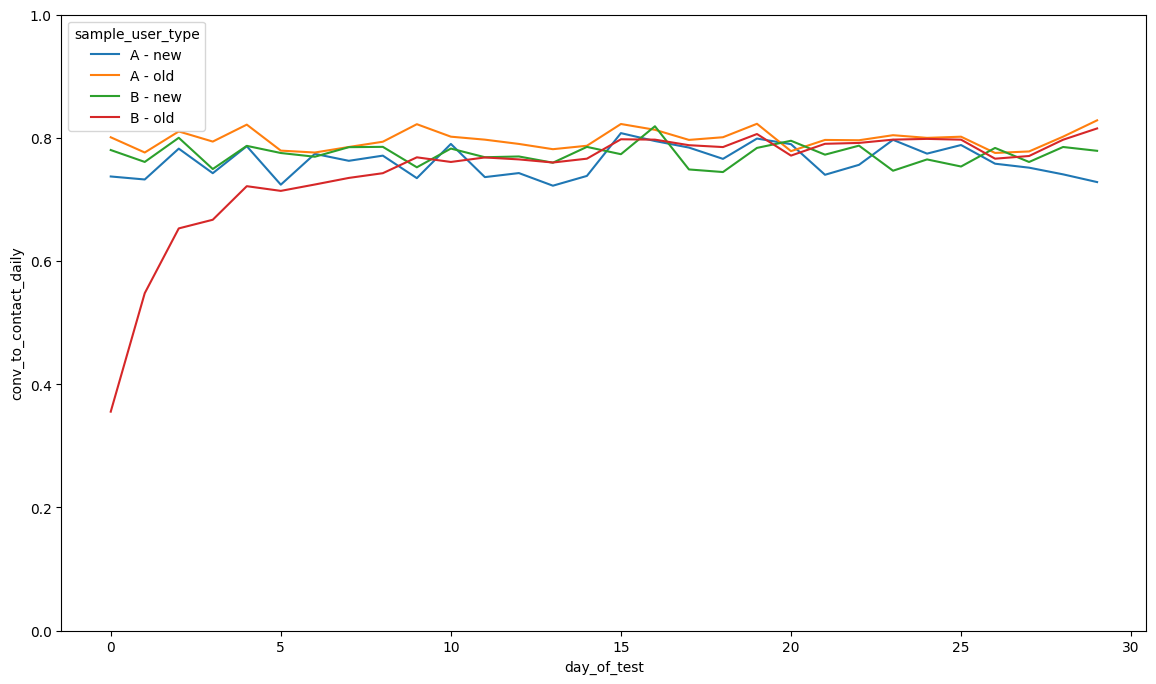

In [16]:
plt.figure(figsize=(14, 8))
df["sample_user_type"] = df["sample_type"] + " - " + df["user_status"]
sns.lineplot(
    data=df,
    x="day_of_test",
    y="conv_to_contact_daily",
    hue="sample_user_type",
    errorbar=None,
)
plt.ylim(0, 1)
plt.show()

In [17]:
df.head()

,user_id,sample_type,date_in_app,first_date_in_app,day_of_test,conv_to_contact_daily,retention_day,user_status,sample_user_type
0,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-02,2023-07-02,22,0,0,new,A - new
1,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-06,2023-07-02,26,0,4,old,A - old
2,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-08,2023-07-02,28,0,6,old,A - old
3,00018D9EB5E146AA8B578E427AEC323A,A,2023-07-09,2023-07-02,29,0,7,old,A - old
4,00027C4F85D64F4A81E95ECCCA1634FE,B,2023-06-14,2023-06-14,4,0,0,new,B - new


### Задание 2. Проверка на сопротивление новому в тесте (2/5)

Рассчитайте среднедневную долю новых пользователей по дням теста (какую долю новые пользователи занимают в дневном трафике в среднем за период теста)

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [19]:
df["status_numeric"] = np.where(df["user_status"] == "new", 1, 0)
avg_news_df = df.groupby("date_in_app", as_index=False).agg(
    new_count=("status_numeric", "sum"),
    all_users_at_day=("user_id", "nunique"),
)

In [22]:
round(
    avg_news_df["new_count"].sum() / avg_news_df["all_users_at_day"].sum(), 3
)

0.029

### Задание 2. Проверка на сопротивление новому в тесте (3/5)

Какое абсолютное значение разницы относительных эффектов на конверсию между "старой" группой и новой группой на 3 день теста (`day_of_test == 2`) (`'conv_deltas_delta'`)?

Для расчета разницы эффектов нам нужно рассчитать несколько вариантов эффекта:

- Относительный эффект между А и Б группой для "старых" пользователей (`'conv_delta_old'`)
- Относительный эффект между А и Б группой для новых пользователей (`'conv_delta_new'`)
- Разницу между относительным эффектом в "старой" группе и таким же эффектом в "новой" группе (`'conv_deltas_delta' = 'conv_delta_new' - 'conv_delta_old'`)

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [38]:
## - Эффект между А и Б группой для "старых" пользователей
## - Эффект между А и Б группой для новых пользователей
## - Разницу между эффектом в "старой" группе и эффектом в "новой" группе
ab_agg = (
    df.groupby(["day_of_test", "user_status", "sample_type"])
    .agg({"conv_to_contact_daily": "mean"})
    .reset_index()
)
ab_agg["sample_user_type"] = (
    ab_agg["sample_type"] + " - " + ab_agg["user_status"]
)

crt_no_effect = ab_agg.pivot(
    index="day_of_test",
    columns="sample_user_type",
    values="conv_to_contact_daily",
).reset_index()
crt_no_effect["conv_delta_new"] = round(
    (crt_no_effect["B - new"] / crt_no_effect["A - new"] - 1), 3
)
crt_no_effect["conv_delta_old"] = round(
    (crt_no_effect["B - old"] / crt_no_effect["A - old"] - 1), 3
)
crt_no_effect["conv_deltas_delta"] = round(
    (crt_no_effect["conv_delta_new"] - crt_no_effect["conv_delta_old"]), 3
)


In [40]:
crt_no_effect

sample_user_type,day_of_test,A - new,A - old,B - new,B - old,conv_delta_new,conv_delta_old,conv_deltas_delta
0,0,0.737179,0.800818,0.780120,0.355381,0.058,-0.556,0.614
1,1,0.732308,0.776104,0.760797,0.547733,0.039,-0.294,0.333
2,2,0.782369,0.810289,0.800000,0.652883,0.023,-0.194,0.217
3,3,0.742500,0.793848,0.749271,0.666943,0.009,-0.160,0.169
4,4,0.786325,0.821354,0.786885,0.721421,0.001,-0.122,0.123
5,5,0.723861,0.779166,0.775281,0.713795,0.071,-0.084,0.155
6,6,0.773885,0.776071,0.769231,0.724132,-0.006,-0.067,0.061
7,7,0.762611,0.785058,0.784768,0.734836,0.029,-0.064,0.093
8,8,0.771014,0.793592,0.785276,0.742510,0.018,-0.064,0.082
9,9,0.734463,0.822057,0.752089,0.768267,0.024,-0.065,0.089


In [39]:
day3_delta = crt_no_effect.loc[
    crt_no_effect["day_of_test"] == 2, "conv_deltas_delta"
].values
print(
    'Абсолютная разница эффекта между "старой" и "новой" группами на 3 день теста составила',
    abs(day3_delta),
)

Абсолютная разница эффекта между "старой" и "новой" группами на 3 день теста составила [0.217]


### Задание 2. Проверка на сопротивление новому в тесте (4/5)

Посчитайте, на какой день теста разница эффектов между "новой" группой и "старой" группой пользователей первый раз становится отрицательной.

Введите значение в поле ниже в формате целого числа.

In [41]:
target_day = crt_no_effect["day_of_test"][
    np.argmax(crt_no_effect["conv_deltas_delta"] < 0)
]
print(
    'Разница эффектов между "новой" группой и "старой" группой пользователей первый раз становится отрицательной на {} день'.format(
        target_day
    )
)

Разница эффектов между "новой" группой и "старой" группой пользователей первый раз становится отрицательной на 15 день


### Задание 2. Проверка на сопротивление новому в тесте (5/5)
 
Есть ли эффект сопротивления новому?

Ответ: Да, т.к. старые пользователи имеют негативный эффект в конверсии в начале теста

# Кейс 2. Эффект новизны

Для практики на определение эффекта новизны мы поработаем с другим кейсом, но на знакомой территории. Менеджеры с ML-командой придумали новый алгоритм поисковой выдачи в автоклассифайде. Алгоритм сложный, требующий дополнительных расходов на поддержание и внедрение в продакшен.

Для того, чтобы понять, стоит ли игра свеч, команда решила протестировать MVP-вариант. В прод запустили параллельного ранжировщика, который ранжирует поисковую выдачу только в тестовой группе В. И раскатили это через А/Б-тест.

Менеджеры считают, что уровень практической значимости = + 1 п.п. (с текущих 88% до 89%). Согласно юнит-экономике, такой прирост дает достаточный прирост покупателей в продукте и повышает эффективность платных услуг.

Надо провести тест и определить, есть ли статистически значимый прирост метрики. Но нужно быть осторожным, т.к. есть риски траты серьезных ресурсов команды. Поэтому дополнительно мы проверим результаты теста на предмет присутствия эффекта новизны.